# Processing, Analysis, Understanding (oh my!)
After the rain events were grouped using DBSCAN, the latent heat profiles were clustered using KMeans. Here we are exploring the results of that second clustering and trying to understand why the clusters were choosen, how they are distinct, as well as how they vary spatial and temporially.

## Loading Data
We start by loading in the output from the KMeans clustering

In [1]:
#import the different packages used throughout
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import math
import datetime
import boto3
from os.path import expanduser
import os
import json
import glob
import calendar
from scipy.stats import skew
import cartopy.crs as ccrs
from pyhdf import SD
from pandas.plotting import scatter_matrix

%matplotlib inline

def download_Data():
    #download the compiled dbscan output and return the xarray data
    home = expanduser("~")

    with open(os.path.join(home,'creds.json')) as creds_file:
        creds_data = json.load(creds_file)

    #Access from S3
    s3 = boto3.resource('s3',aws_access_key_id=creds_data['key_id'],
             aws_secret_access_key=creds_data['key_access'],region_name='us-west-2')
    bucket = s3.Bucket('himatdata')
    home = os.getcwd()

    #download the file (note this is a big, 10+ GB file)
    bucket.download_file('Trmm/EPO/Cluster_results_March15/DB_compiled_Clustered_Data.nc4',
                         os.path.join(os.path.join(home,'S3_downloads/DB_compiled_Clustered_Data.nc4')))
def load_Data():
    #open the local copy
    F = xr.open_dataset('S3_downloads/DB_Kmeans_compiled_Clustered_Data.nc4')

    return F

# download_Data()

F = load_Data()

## Plot Clusters
For the Kmeans algorithm, 5 clusters were specified as this is where the the inner cluster variation (reflected in the sum of squared distance between each observation and it's cluster center) starts to plateau as well as where the silohette score (a measure of how similar observations are within their own cluster compared to how other clusters) is locally maximized. According to the silhoutte score alone, only 2 clusters should be used to maximize the cluster differences, but this is clearly not the elbow of the inner cluster variation.

In [2]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

n_clusters = range(2,15)

#stndardize the data before clustering
Xscaler = StandardScaler()
X = Xscaler.fit_transform(F['DB_means Latent Heat'])

#empty matrix to hold output from clustering
met = np.zeros((len(n_clusters),5))
met2 = np.zeros(len(n_clusters))
#for each number of clusters to create, fit the k means and calculate the silhouette score nscore times
for i in range(len(n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters[i], random_state=0).fit(X)
    met2[i] = kmeans.inertia_
    for j in range(5):
        met[i,j] = metrics.silhouette_score(X, kmeans.labels_, sample_size=10000, random_state=j*10)


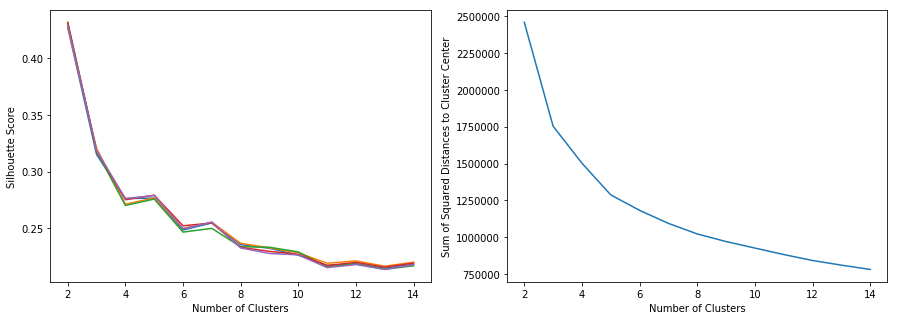

In [3]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(n_clusters,met);
plt.ylabel('Silhouette Score');
plt.xlabel('Number of Clusters');
plt.subplot(1,2,2)
plt.plot(n_clusters,met2);
plt.ylabel('Sum of Squared Distances to Cluster Center')
plt.xlabel('Number of Clusters');

We then plot the cluster centers. We also explore how the clusters are related using a dendogram plot

In [4]:
def plot_centers(F):
    fig = plt.figure(figsize=(14,10))

    for i in range(len(F.K_centers)):
        ax = plt.subplot(2, 3, i+1)
        percent_clus = len(F['KlabelDB'][F['KlabelDB']==i])/len(F['KlabelDB'])*100
        a = ax.plot(F.K_centers[i,:],F.altitude);
        plt.title('Cluster ' + str(i+1) + ' : ' + str(round(percent_clus)) + '%')
        plt.xlim(-2,12)
        if i==0 or i==3:
            plt.ylabel('Altitude (km)')
        else: plt.yticks([])
        if i>1:
            plt.xlabel('Latent Heat')
        else: plt.xticks([])

Text(0.5,1,'Latent Heat Clusters')

/anaconda3/envs/precip/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


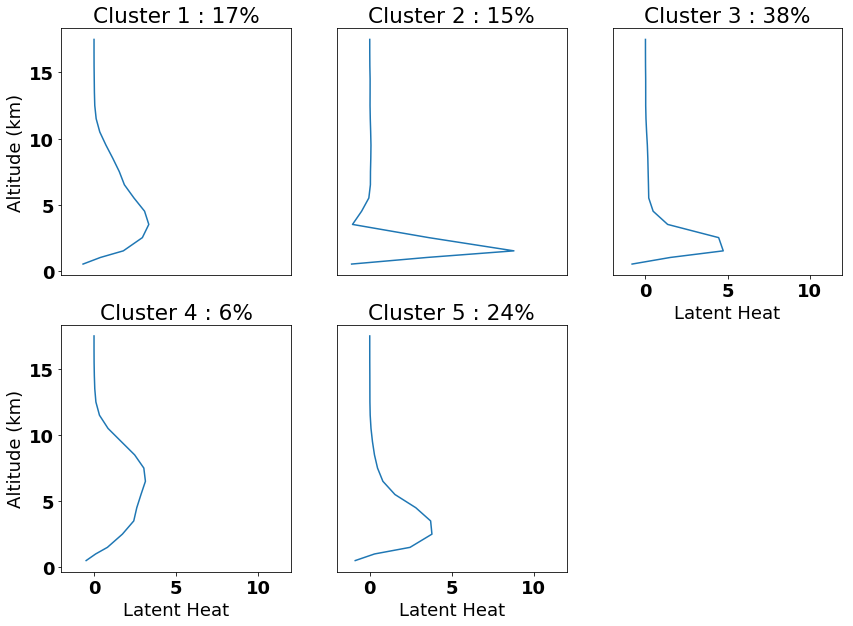

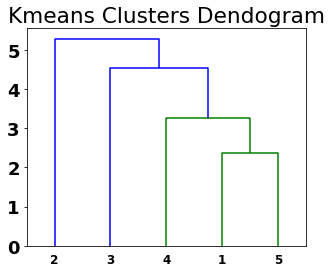

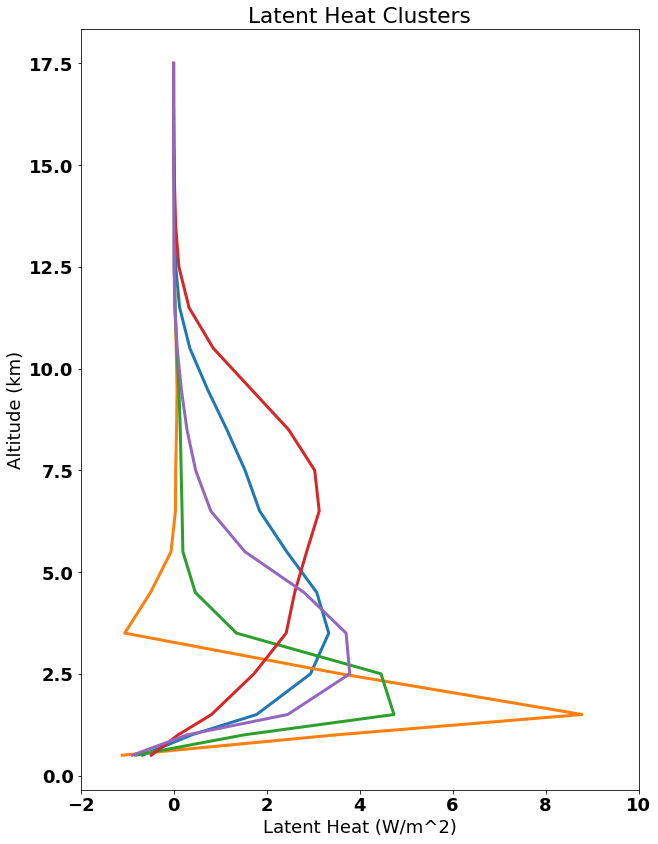

In [5]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

plot_centers(F)

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

D = pdist(np.array(F.K_centers))

fig = plt.figure(figsize=(5,4))
linkage_matrix = linkage(D, "single")
dendrogram(linkage_matrix, labels=["1", "2", "3","4","5"]);
plt.title("Kmeans Clusters Dendogram");

fig = plt.figure(figsize=(10,14))
for i in range(len(F.K_centers)):
    plt.plot(F.K_centers[i,:],F.altitude,linewidth=3);
plt.xlim(-2,10)
plt.ylabel('Altitude (km)')
plt.xlabel('Latent Heat (W/m^2)')
plt.title('Latent Heat Clusters')


## Why These Clusters?
Visually, it's clear the clusters are distinct but to get a better understanding as to where the main differences lie, we use a countour matrix plot, which shows the relationship between variables used in the clustering. It's clear from the graphs above, that all the variability falls in latent heating below about 11 km. For this reason, we restrict the contour matrix plots to only the heating in these lower layers, for simplicity of adsorbing information.

To start, we look at the complete set of rain events

In [6]:
import numpy as np

from pandas.compat import lmap, lrange, range, zip
from pandas.util._decorators import deprecate_kwarg
import matplotlib.colors as colors
from pandas.core.dtypes.missing import notna

from pandas.io.formats.printing import pprint_thing
from pandas.plotting._style import _get_standard_colors
from pandas.plotting._tools import _set_ticks_props, _subplots


def contour_matrix(frame, alpha=0.5, figsize=None, ax=None, grid=False,
                   diagonal='hist', marker='.', density_kwds=None,
                   hist_kwds=None, range_padding=0.05, **kwds):
    """
    Draw a matrix of scatter plots.
    Parameters
    ----------
    frame : DataFrame
    alpha : float, optional
        amount of transparency applied
    figsize : (float,float), optional
        a tuple (width, height) in inches
    ax : Matplotlib axis object, optional
    grid : bool, optional
        setting this to True will show the grid
    diagonal : {'hist', 'kde'}
        pick between 'kde' and 'hist' for
        either Kernel Density Estimation or Histogram
        plot in the diagonal
    marker : str, optional
        Matplotlib marker type, default '.'
    hist_kwds : other plotting keyword arguments
        To be passed to hist function
    density_kwds : other plotting keyword arguments
        To be passed to kernel density estimate plot
    range_padding : float, optional
        relative extension of axis range in x and y
        with respect to (x_max - x_min) or (y_max - y_min),
        default 0.05
    kwds : other plotting keyword arguments
        To be passed to scatter function
    Examples
    --------
    >>> df = pd.DataFrame(np.random.randn(1000, 4), columns=['A','B','C','D'])
    >>> scatter_matrix(df, alpha=0.2)
    """

    df = frame._get_numeric_data()
    n = df.columns.size
    naxes = n * n
    fig, axes = _subplots(naxes=naxes, figsize=figsize, ax=ax,
                          squeeze=False)

    # no gaps between subplots
    fig.subplots_adjust(wspace=0, hspace=0)

    mask = notna(df)

    hist_kwds = hist_kwds or {}
    density_kwds = density_kwds or {}

    # GH 14855
    kwds.setdefault('edgecolors', 'none')

    boundaries_list = []
    for a in df.columns:
        values = df[a].values[mask[a].values]
        rmin_, rmax_ = np.min(values), np.max(values)
        rdelta_ext = (rmax_ - rmin_) * range_padding / 2.
        boundaries_list.append((rmin_ - rdelta_ext, rmax_ + rdelta_ext))

    for i, a in zip(lrange(n), df.columns):
        for j, b in zip(lrange(n), df.columns):
            ax = axes[i, j]

            if i == j:
                values = df[a].values[mask[a].values]

                # Deal with the diagonal by drawing a histogram there.
                if diagonal == 'hist':
                    ax.hist(values, bins = [np.linspace(-5,15)],**hist_kwds)

                elif diagonal in ('kde', 'density'):
                    from scipy.stats import gaussian_kde
                    y = values
                    gkde = gaussian_kde(y)
                    ind = np.linspace(-5, 15, 1000)
                    ax.plot(ind, gkde.evaluate(ind), **density_kwds)

#                 ax.set_xlim(boundaries_list[i])

            else:
                common = (mask[a] & mask[b]).values

                ax.hist2d(df[b][common], df[a][common],bins = [np.linspace(-5,15), np.linspace(-5,15)], 
                          norm=colors.LogNorm())

#                 ax.set_xlim(boundaries_list[j])
#                 ax.set_ylim(boundaries_list[i])

            ax.set_xlabel(b)
            ax.set_ylabel(a)

            if j != 0:
                ax.yaxis.set_visible(False)
            if i != n - 1:
                ax.xaxis.set_visible(False)

    if len(df.columns) > 1:
        lim1 = boundaries_list[0]
        locs = axes[0][1].yaxis.get_majorticklocs()
        locs = locs[(lim1[0] <= locs) & (locs <= lim1[1])]
        adj = (locs - lim1[0]) / (lim1[1] - lim1[0])

        lim0 = axes[0][0].get_ylim()
        adj = adj * (lim0[1] - lim0[0]) + lim0[0]
#         axes[0][0].yaxis.set_ticks(adj)

        if np.all(locs == locs.astype(int)):
            # if all ticks are int
            locs = locs.astype(int)
#         axes[0][0].yaxis.set_ticklabels(locs)

    _set_ticks_props(axes, xlabelsize=8, xrot=90, ylabelsize=8, yrot=0)

    return axes

/anaconda3/envs/precip/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


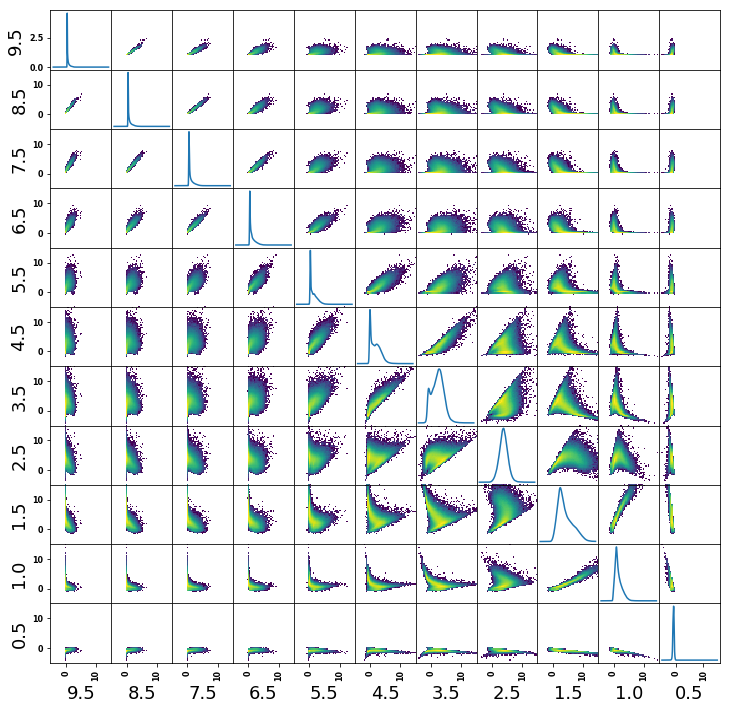

In [7]:
df = pd.DataFrame(data = np.fliplr(np.array(F['DB_means Latent Heat'][:,0:11])), 
                  columns = np.flipud(np.array(F.altitude[0:11])))
contour_matrix(df, figsize=(12, 12), diagonal='kde');

It's clear there is some structure within the data itself. For instance, there tends to be positive correlation between adjacent heights, which is to be expected. 

We next look at each individual cluster to try and spot key differences between them.

/anaconda3/envs/precip/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


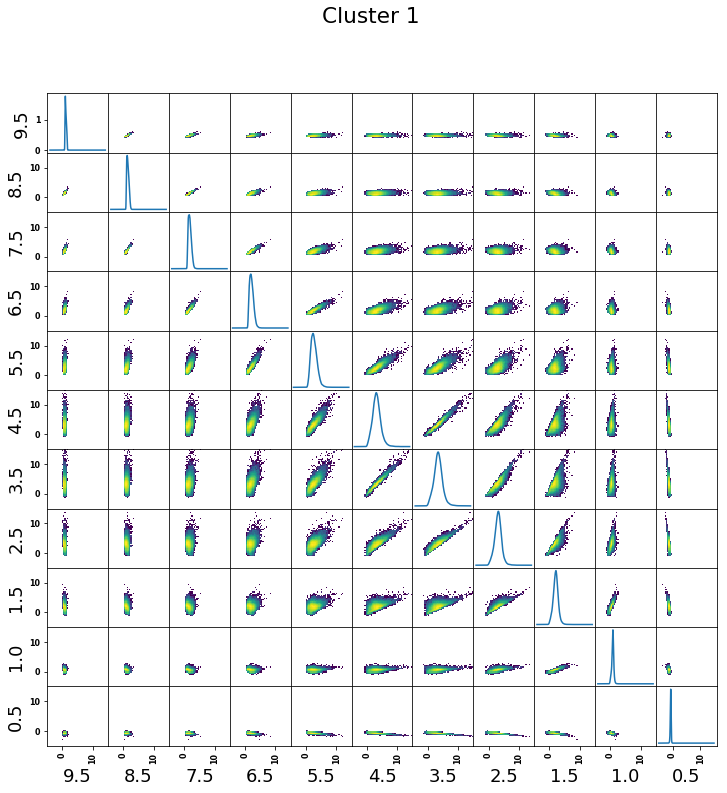

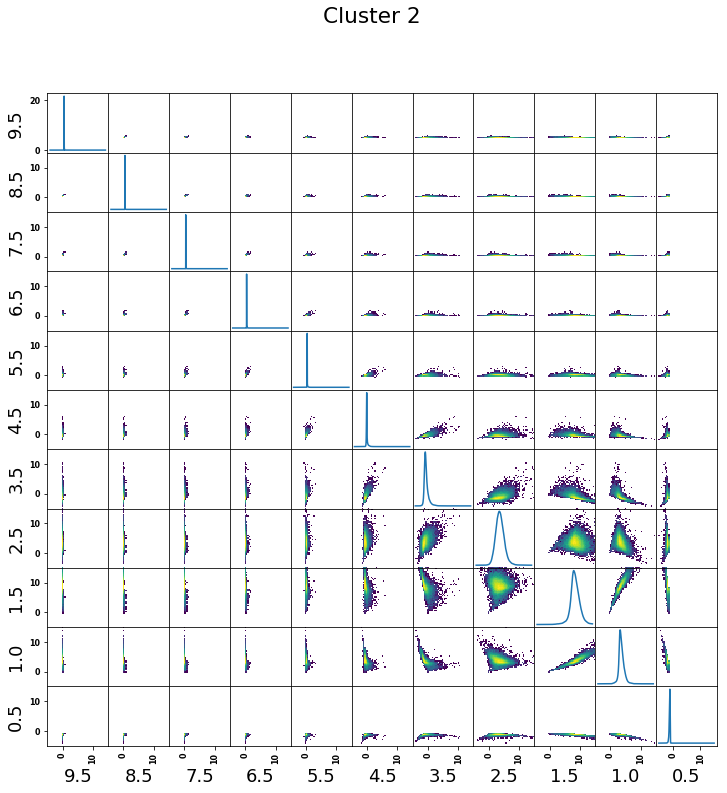

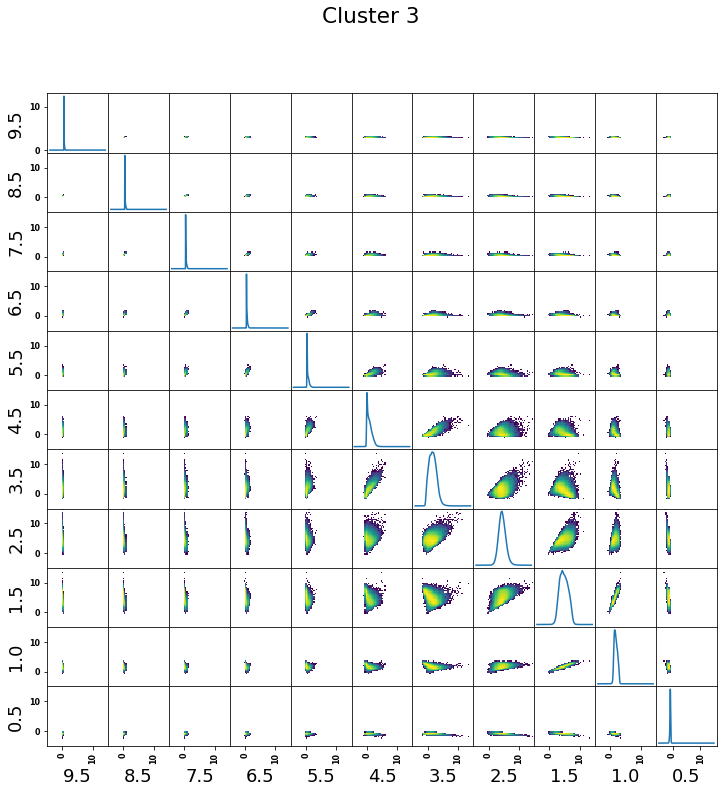

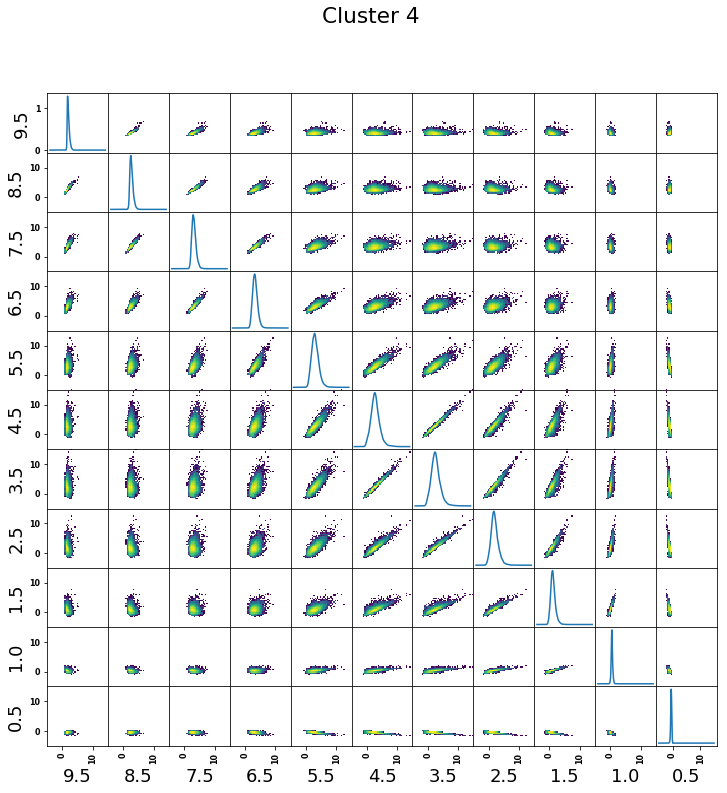

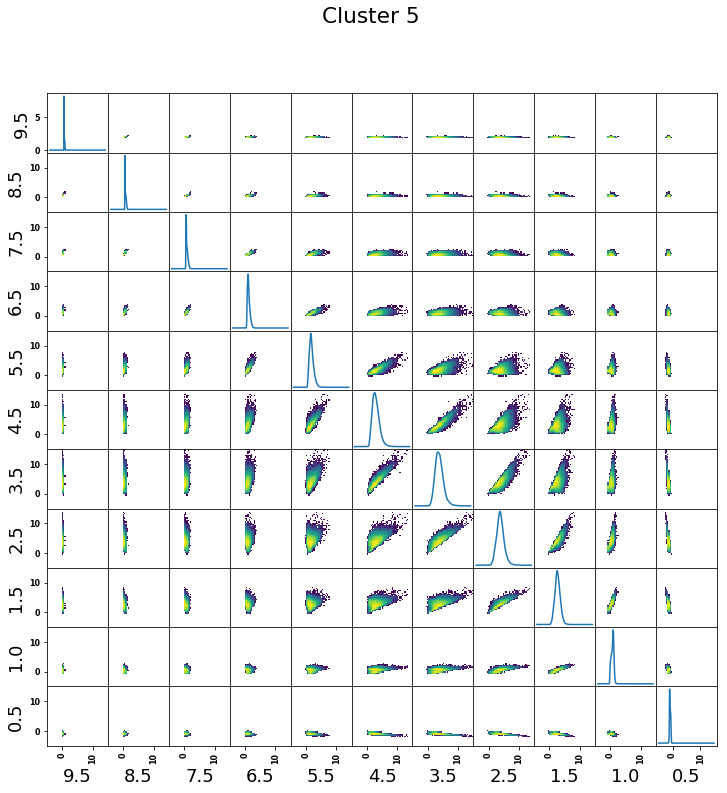

In [8]:
for i in range(len(np.unique(F.KlabelDB))):
    df = pd.DataFrame(data = np.fliplr(np.array(F['DB_means Latent Heat'][F['KlabelDB']==i,0:11])), 
                      columns= np.flipud(np.array(F.altitude[0:11])))
    c = contour_matrix(df, figsize=(12, 12), diagonal='kde');
    plt.suptitle('Cluster ' +str(i+1))

Next we look at how the rain rate and rain area are distributed between the clusters, as well as over the whole dataset.

In [9]:
def plot_Stats(F):
    fig = plt.figure(figsize=(8,5))
    plt.hist2d(F['DB_count'],F['DB_means Rain Rate'],range=[[0,10000],[0,20]],norm=colors.LogNorm())
    plt.title('Mean of Event Spans')
    plt.xlabel('Cluster Extent (Observations)')
    plt.ylabel('Average Rain Rate (mm/hr)')
    plt.colorbar().set_label('Frequency')

In [10]:
def plot_ClusterStats(F,clusternum):
    fig = plt.figure(figsize=(8,5))
    plt.hist2d(F['DB_count'][F['KlabelDB']==clusternum],F['DB_means Rain Rate'][F['KlabelDB']==clusternum],
               range=[[0,10000],[0,20]],norm=colors.LogNorm())
    plt.xlabel('Cluster Extent (Observations)')
    plt.ylabel('Average Rain Rate (mm/hr)')
    plt.colorbar().set_label('Frequency')

/anaconda3/envs/precip/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


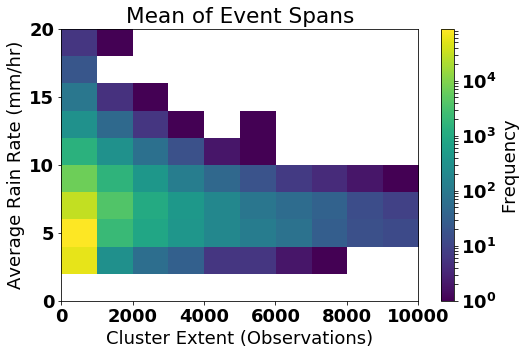

In [11]:
plot_Stats(F)

/anaconda3/envs/precip/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


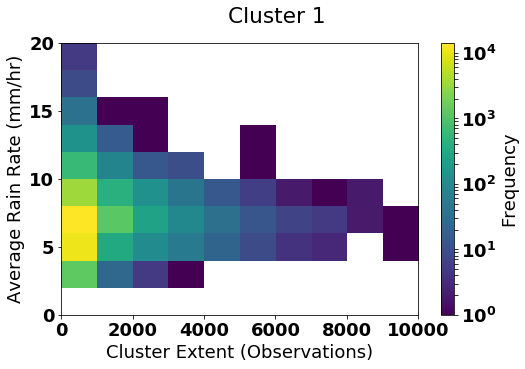

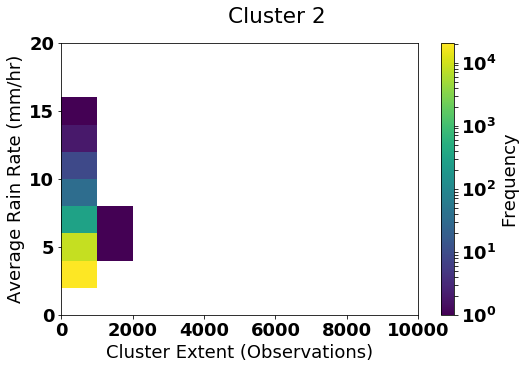

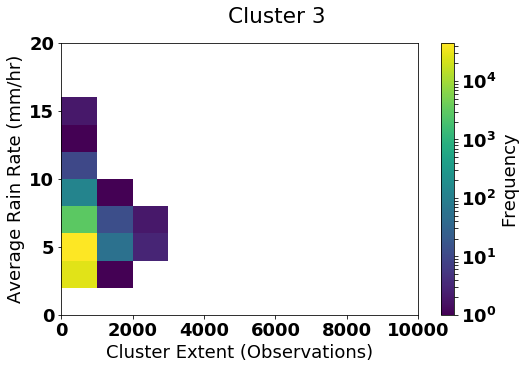

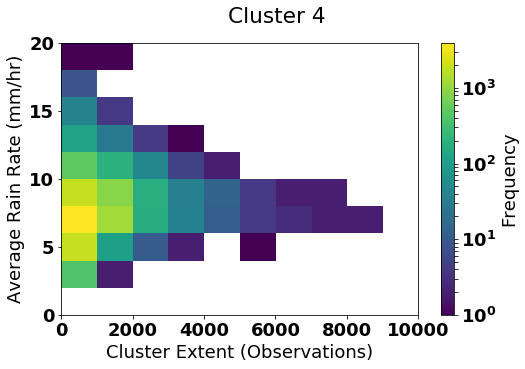

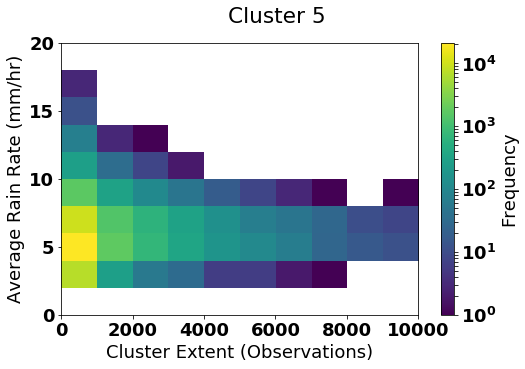

In [12]:
for i in range(len(np.unique(F.KlabelDB))):
    plot_ClusterStats(F,i)
    plt.suptitle('Cluster ' +str(i+1))

Next we look at how the clusters are distributed in space by plotting heatmaps of their occurance frequency

In [13]:
def heat_map_byCluster_annual(cluster_number,F):
  
    Lat = F.Latitude
    Lon = F.Longitude
    
    ind = F.KLabel==cluster_number
    Lat = Lat[ind]
    Lon = Lon[ind]
    
    LatLon = np.dstack((np.round(Lat),np.round(Lon)))
    pairs, counts = np.unique(LatLon[0],axis=0,return_counts=1)
    print('made pairs')
    bbox = [-40,40,140,260]
    fig = plt.figure(figsize=(5,4))

    # Define the projection, scale, the corners of the map, and the resolution.
    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
    cmap = plt.get_cmap('gist_earth')
    m.drawcoastlines()

    im = m.scatter(pairs[:,1]+360, pairs[:,0], latlon=True,c=counts/16,vmin=0,vmax=250)
    plt.suptitle('Cluster ' +str(cluster_number+1))
    cbar_ax = fig.add_axes([0.95, 0.11, 0.02, 0.8])
    fig.colorbar(im, cax=cbar_ax, label='Event Frequency')

made pairs
made pairs
made pairs
made pairs
made pairs


/anaconda3/envs/precip/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


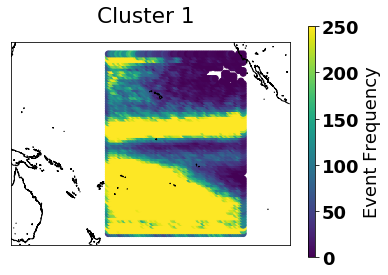

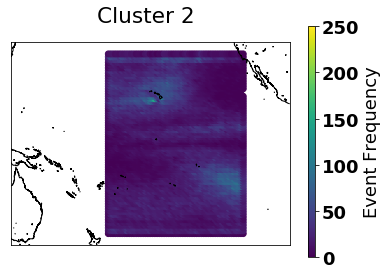

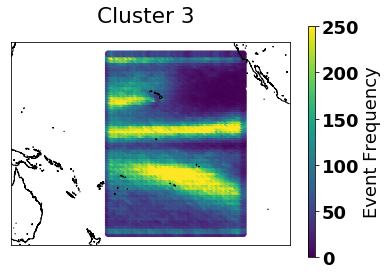

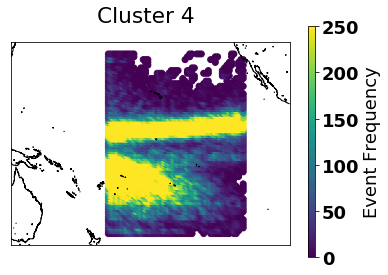

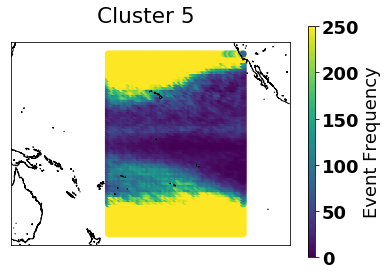

In [14]:
for i in range(5):
    heat_map_byCluster_annual(i,F)

From these images, it's clear that some of the clusters are associated with more storm-track precipitation events rather than tropical events, particularly cluster 5. Looking only at those clusters associated with tropical precipitation, we can explore how their spatial structure changes in time. We start by looking at the seasonal cycle for those clusters.

In [15]:
def heat_map_byCluster(monthToPlot,cluster_number,F):
    Time = np.array(F.Time.dt.month)
    
    
    Lat = F.Latitude
    Lon = F.Longitude
    
    ind = F.KLabel==cluster_number
    time = Time[ind]
    Lat = Lat[ind]
    Lon = Lon[ind]
    ind = time==monthToPlot
    Lat = Lat[ind]
    Lon = Lon[ind]
    
    LatLon = np.dstack((np.round(Lat),np.round(Lon)))
    pairs, counts = np.unique(LatLon[0],axis=0,return_counts=1)
    
    return(pairs,counts)

In [16]:
def heat_map_allMonths_byCluster(cluster_number,F):
    bbox = [-40,40,140,260]
    fig = plt.figure(figsize=(16,14))

    for i in range(1,13):
        pairs,counts = heat_map_byCluster(i,cluster_number,F)
        ax = plt.subplot(4, 3, i)
        # Define the projection, scale, the corners of the map, and the resolution.
        m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
        cmap = plt.get_cmap('gist_earth')
        m.drawcoastlines()

        im = m.scatter(pairs[:,1]+360, pairs[:,0], latlon=True,c=counts/16,vmin=0,vmax=75)
        
        plt.title(calendar.month_name[i])
        
    cbar_ax = fig.add_axes([0.95, 0.11, 0.02, 0.8])
    fig.colorbar(im, cax=cbar_ax, label='Event Frequency')
    fig.suptitle('Cluster ' +str(cluster_number+1))


The plots belows show the seasonal variability of each precipitation mode associated with tropical precipitation. You can clearly see the ITCZ moving with the seasons, as well as the SPCZ in Southern Hemisphere summer

/anaconda3/envs/precip/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


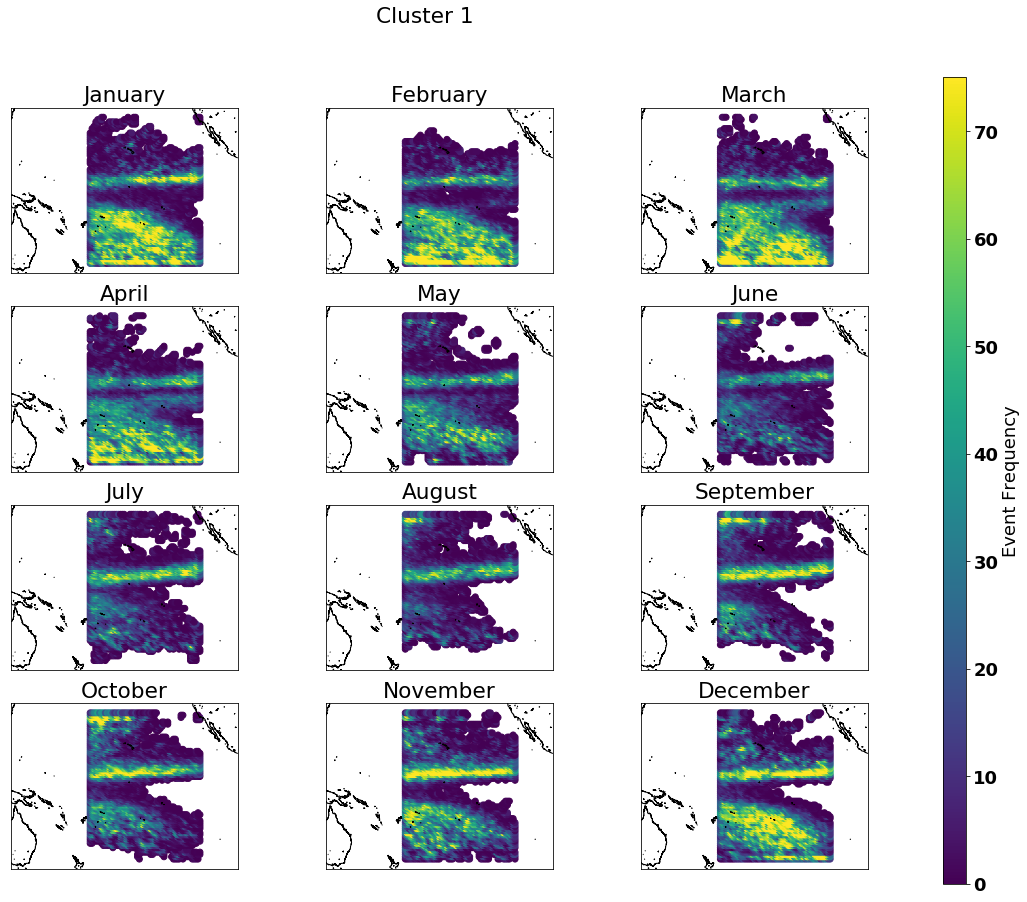

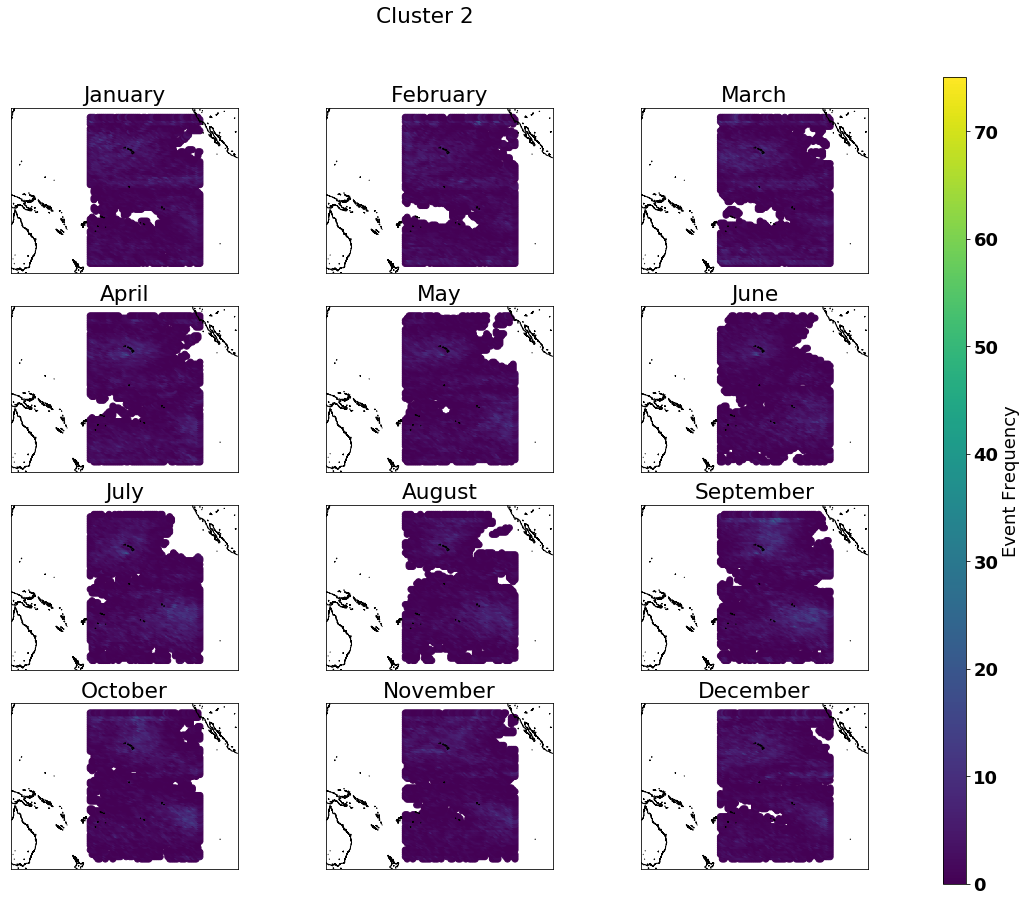

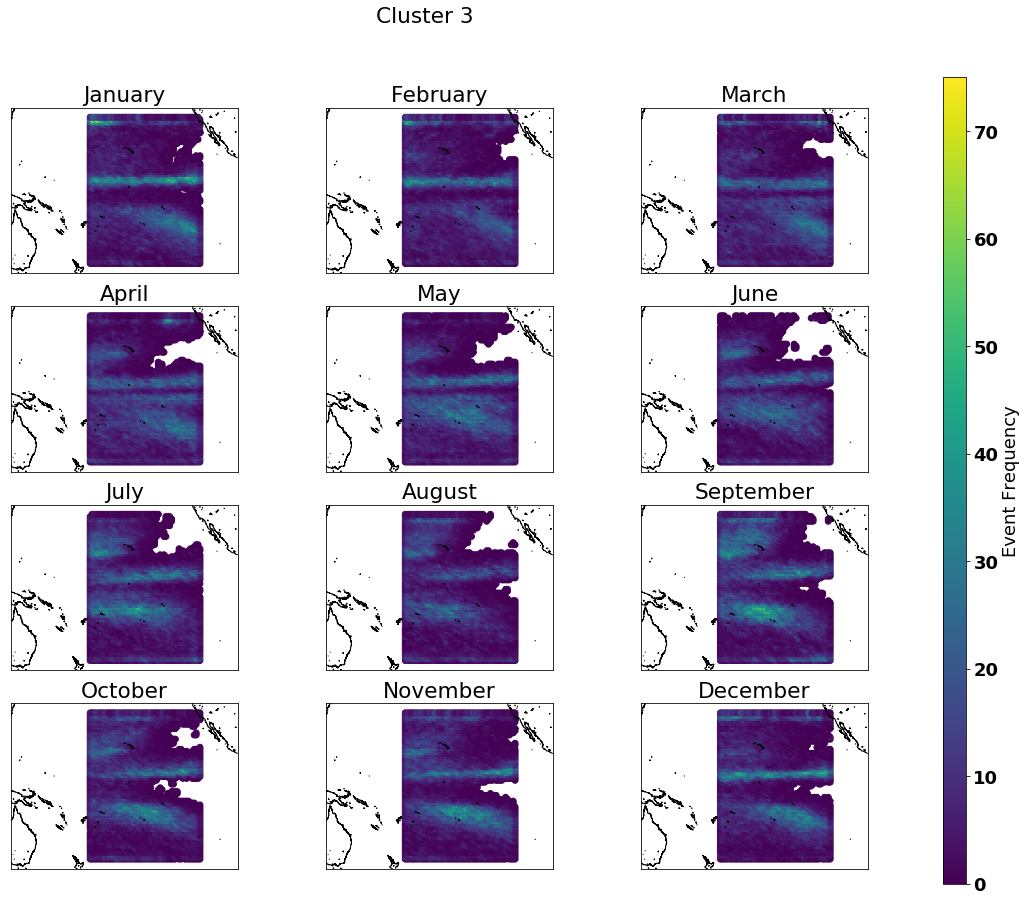

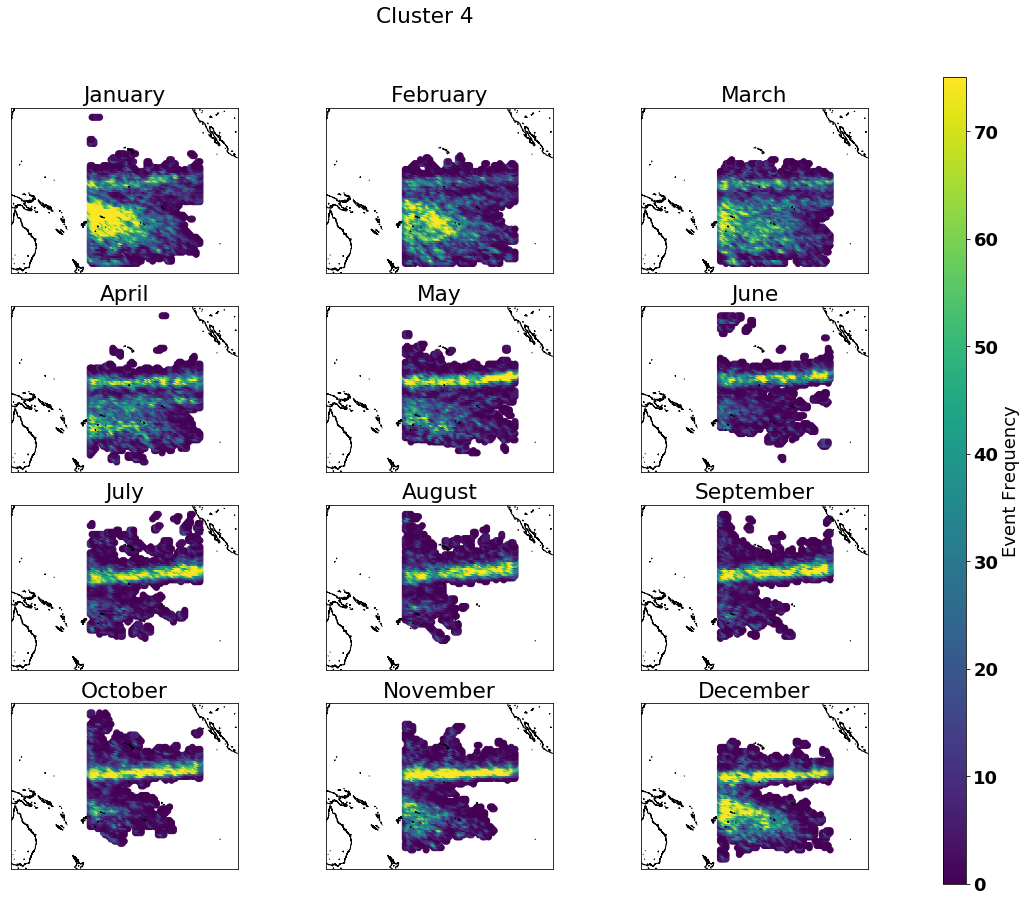

In [17]:
clusternumbers = [0,1,2,3]
for i in range(len(clusternumbers)):
    heat_map_allMonths_byCluster(clusternumbers[i],F)

We can also look at how these cluster spatial structures vary in response to ENSO. To investigate this, we plot the difference in occurance frequency of each mode between composite El Nino and La Nina years.

In [18]:
def heat_map_byCluster_MonthYear(monthToPlot,yearToPlot,cluster_number,F):
    Time = np.array(F.Time.dt.month)
    Year = np.array(F.Time.dt.year)
    
    Lat = F.Latitude
    Lon = F.Longitude
    
    ind = F.KLabel==cluster_number
    year = Year[ind]
    time = Time[ind]
    Lat = Lat[ind]
    Lon = Lon[ind]
    ind = year==yearToPlot
    time = time[ind]
    Lat = Lat[ind]
    Lon = Lon[ind]
    ind = time==monthToPlot
    Lat = Lat[ind]
    Lon = Lon[ind]
    Lon[Lon<0]+=360
    
    LatLon = np.dstack((np.round(Lat),np.round(Lon)))
    pairs, counts = np.unique(LatLon[0],axis=0,return_counts=1)
    
    return(np.array(pairs),np.array(counts))

In [19]:
def nino_nina_Diff_Plot(month,clusterNum,F):
    nino = open('/Users/lauren/Downloads/nino34.long.anom.data','r')
    count = 0
    NINO34 = np.zeros((16,12))
    for line in nino:
        values = line.split()
        if (float(values[0]) > 1997) & (float(values[0])<2014):
            NINO34[count,:] = np.asarray(values[1:], dtype=np.float32)
            count += 1
        if count == 16: break

    COUNTS= []
    PAIRS=[]
    NinoIndex = np.argwhere(NINO34[:,month-1]>0.5)
    NinoYear = 1998+np.argwhere(NINO34[:,month-1]>0.5)
    
    try:
        for i in range(len(NinoYear)):
            pairs, counts = heat_map_byCluster_MonthYear(month,NinoYear[i],clusterNum,F)
            Counts = NINO34[int((NinoYear[i]-1998)),month-1]*counts
            nrows, ncols = pairs.shape
            dtype={'names':['f{}'.format(i) for i in range(ncols)],
               'formats':ncols * [pairs.dtype]}
            if i>0:
                C,pind,Pind = np.intersect1d(pairs.view(dtype), PAIRS.view(dtype),return_indices=True)
                COUNTS[Pind]+=NINO34[int((NinoYear[i]-1998)),0]*counts[pind]
                Counts = np.delete(Counts,pind)
                pairs = np.delete(pairs,pind,axis=0)
                PAIRS = np.concatenate((PAIRS,pairs))
                COUNTS = np.concatenate((COUNTS,Counts))
            else:
                PAIRS = pairs
                COUNTS = Counts
    except:
        PAIRS = np.array([[0,0]])
        COUNTS = np.array([0])
        nrows, ncols = PAIRS.shape
        dtype={'names':['f{}'.format(i) for i in range(ncols)],
               'formats':ncols * [PAIRS.dtype]}

        
    NinaIndex = np.argwhere(NINO34[:,month-1]<-0.5)
    NinaYear = 1998+np.argwhere(NINO34[:,month-1]<-0.5)
    
    try:
        for i in range(len(NinoYear)):
            Apairs, Acounts = heat_map_byCluster_MonthYear(month,NinaYear[i],clusterNum,F)
            ACounts = NINO34[int((NinaYear[i]-1998)),month-1]*Acounts
            nrows, ncols = Apairs.shape
            dtype={'names':['f{}'.format(i) for i in range(ncols)],
               'formats':ncols * [Apairs.dtype]}
            if i>0:
                C,pind,Pind = np.intersect1d(Apairs.view(dtype), APAIRS.view(dtype),return_indices=True)
                ACOUNTS[Pind]+=NINO34[int((NinaYear[i]-1998)),0]*Acounts[pind]
                ACounts = np.delete(ACounts,pind)
                Apairs = np.delete(Apairs,pind,axis=0)
                APAIRS = np.concatenate((APAIRS,Apairs))
                ACOUNTS = np.concatenate((ACOUNTS,ACounts))
            else:
                APAIRS = Apairs
                ACOUNTS = ACounts
    except:
        APAIRS = np.array([[0,0]])
        ACOUNTS = np.array([0])
        nrows, ncols = APAIRS.shape
        dtype={'names':['f{}'.format(i) for i in range(ncols)],
               'formats':ncols * [APAIRS.dtype]}
        
        
    C,mind,Pind = np.intersect1d(APAIRS.view(dtype), PAIRS.view(dtype),return_indices=True)
    print(np.sum(NINO34[NinaIndex,month-1]))
    Counts = COUNTS[Pind]/np.sum(NINO34[NinoIndex,month-1])+ACOUNTS[mind]/np.sum(NINO34[NinaIndex,month-1])
    Pairs = PAIRS[Pind,:]
    Counts = np.concatenate((Counts,COUNTS[~Pind]/np.sum(NINO34[NinoIndex,month-1])))
    Pairs = np.concatenate((Pairs,PAIRS[~Pind,:]))
    Counts = np.concatenate((Counts,ACOUNTS[~mind]/np.sum(NINO34[NinaIndex,month-1])))
    Pairs = np.concatenate((Pairs,APAIRS[~mind,:]))

    return Pairs, Counts


In [20]:
def heat_map_NinoallMonths_byCluster(cluster_number,F):
    bbox = [-40,40,140,260]
    fig = plt.figure(figsize=(16,14))

    for i in range(1,13):
        pairs,counts = nino_nina_Diff_Plot(i,cluster_number,F)
        ax = plt.subplot(4, 3, i)
        # Define the projection, scale, the corners of the map, and the resolution.
        m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
        m.drawcoastlines()

        im = m.scatter(pairs[:,1], pairs[:,0], latlon=True,c=counts,vmin=-25,vmax=25,cmap='bwr',s=5)
        
        plt.title(calendar.month_name[i])
        
    cbar_ax = fig.add_axes([0.95, 0.11, 0.02, 0.8])
    fig.colorbar(im, cax=cbar_ax, label='Event Frequency')
    fig.suptitle('Cluster ' +str(cluster_number+1))


-10.599999964237213
-8.559999942779541
-5.780000030994415
-3.240000009536743
-3.35999995470047
-2.3199999928474426
-3.0299999713897705
-4.370000064373016
-5.019999861717224
-6.75
-7.630000114440918
-9.909999907016754
-10.599999964237213
-8.559999942779541
-5.780000030994415
-3.240000009536743
-3.35999995470047
-2.3199999928474426
-3.0299999713897705
-4.370000064373016
-5.019999861717224
-6.75
-7.630000114440918
-9.909999907016754
-10.599999964237213
-8.559999942779541
-5.780000030994415
-3.240000009536743
-3.35999995470047
-2.3199999928474426
-3.0299999713897705
-4.370000064373016
-5.019999861717224
-6.75
-7.630000114440918
-9.909999907016754
-10.599999964237213
-8.559999942779541
-5.780000030994415
-3.240000009536743
-3.35999995470047
-2.3199999928474426
-3.0299999713897705
-4.370000064373016
-5.019999861717224
-6.75
-7.630000114440918
-9.909999907016754


/anaconda3/envs/precip/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


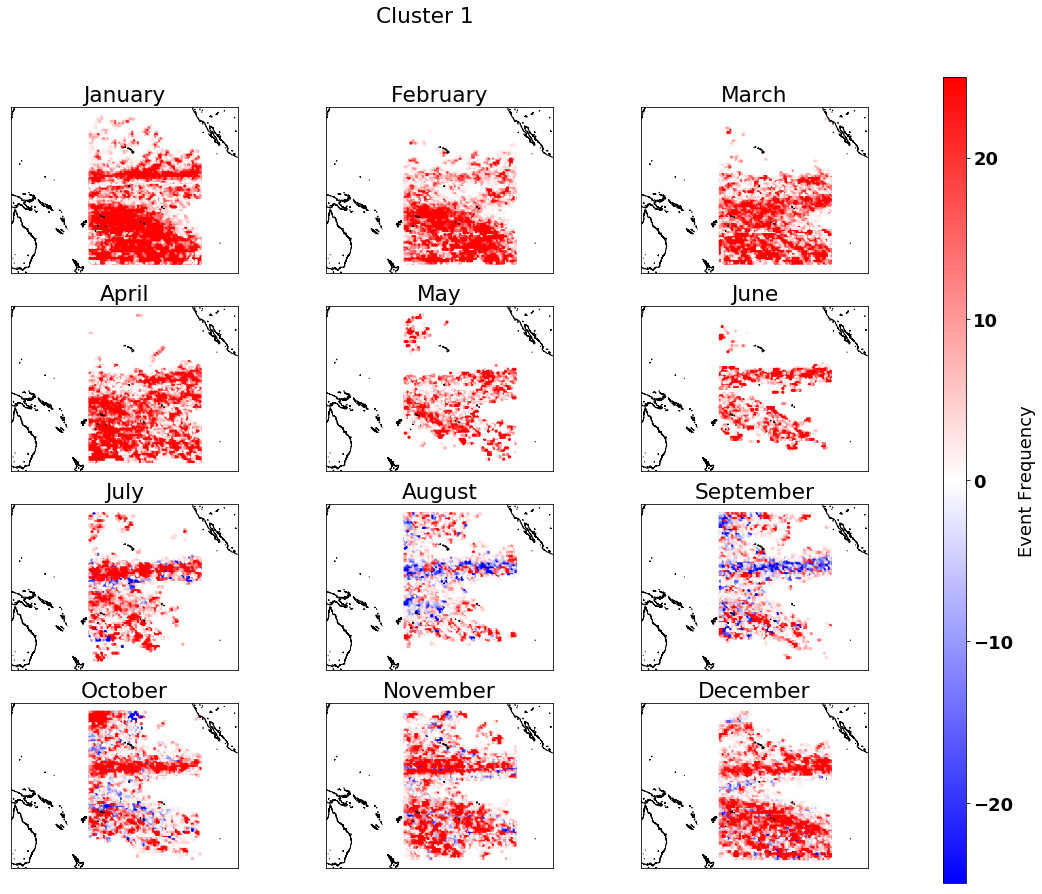

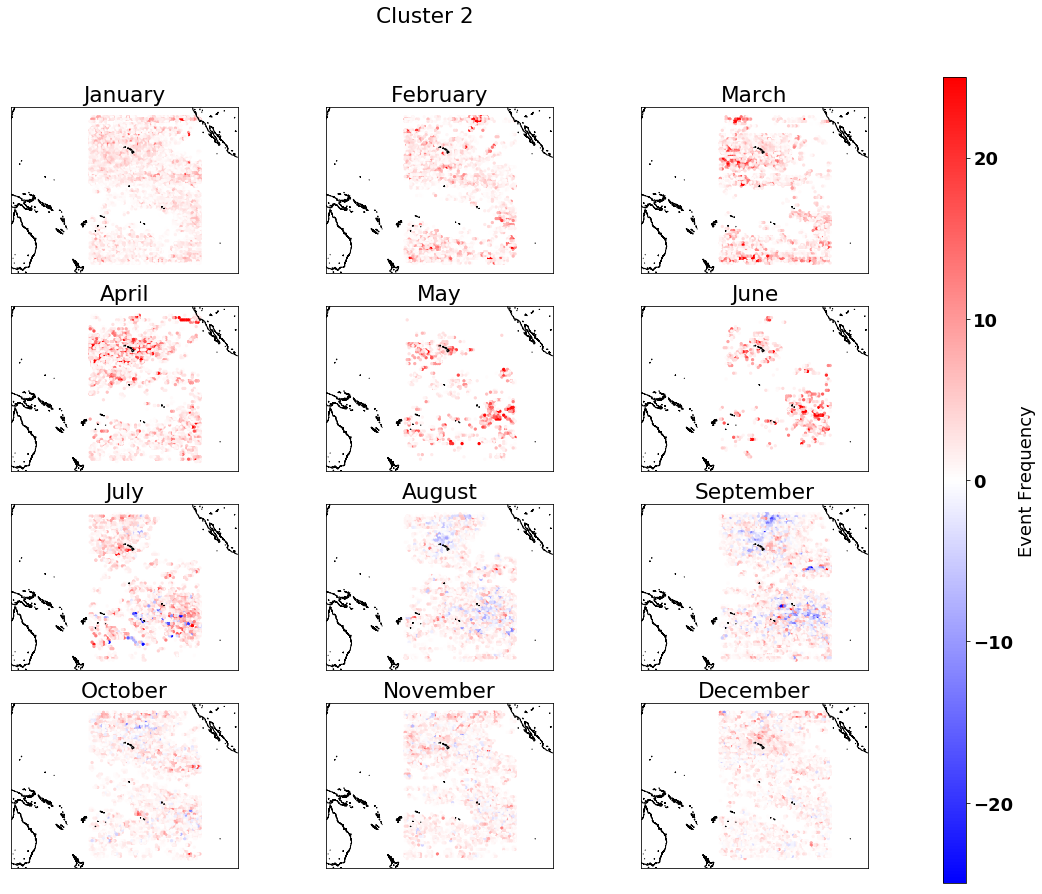

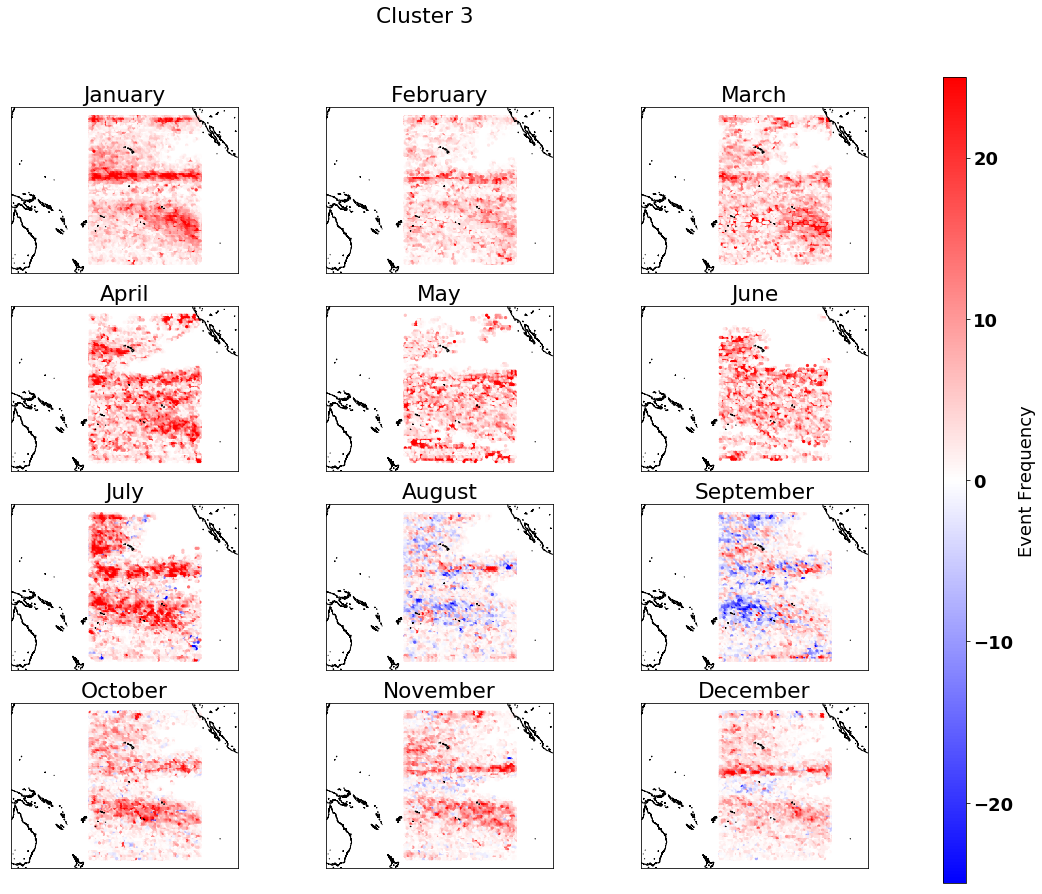

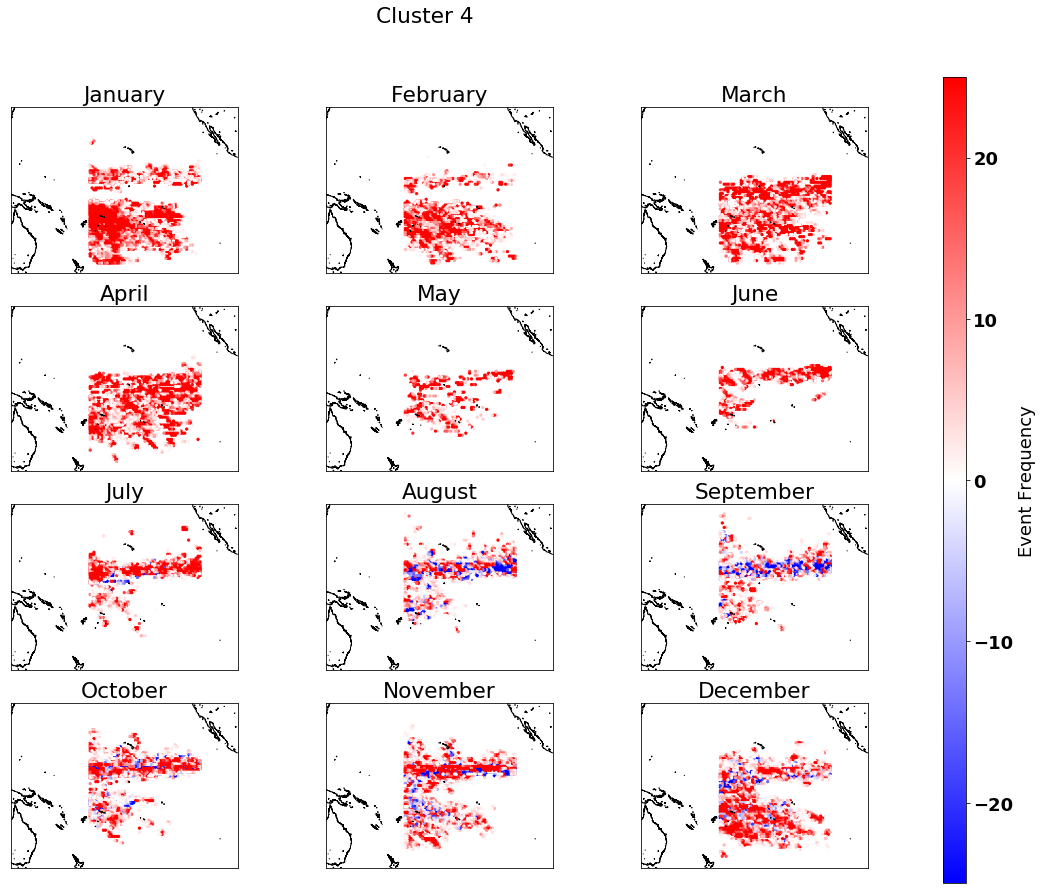

In [22]:
for i in range(len(clusternumbers)):
    heat_map_NinoallMonths_byCluster(clusternumbers[i],F)